## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models


In [13]:
from pathlib import Path
from tqdm.auto import tqdm

import pandas as pd

import torch
from transformers import pipeline
from transformers.models.whisper import (WhisperTokenizer,
                                         WhisperTokenizerFast,
                                         WhisperFeatureExtractor,
                                         WhisperForConditionalGeneration)
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

from dataloader.dataset_loader import gen_from_dataset
from dataloader.dataset_for_evaluation.ami_test import AMITestSet

from utils.whisper_hallucinations.get_features import compute_gzip_compression_ratio
from utils.constants import GEN_MAX_LENGTH

device = torch.device('mps')
sns.set_theme(context="paper", style="ticks")

OUTPUT_DIR = Path("notebooks/outputs/tac/")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## User input

## Load model

In [4]:
pretrained_model_name_or_path = "openai/whisper-tiny"

model = WhisperForConditionalGeneration.from_pretrained(pretrained_model_name_or_path).to(device)
feature_extractor = WhisperFeatureExtractor.from_pretrained(pretrained_model_name_or_path)
tokenizer = WhisperTokenizerFast.from_pretrained(pretrained_model_name_or_path)

whisper_norm = tokenizer._normalize

## Load dataset

In [5]:
ds_group = AMITestSet()

Found cached dataset ami (/Users/Tony/.cache/huggingface/datasets/edinburghcstr___ami/ihm/0.0.0/0d128d0aa8145d0f16f3d5b4da86c5d5759dbe9e8f947fda04b25edb56442bd5)


In [6]:
ds = ds_group.str2dataset["ami"]

ds

Dataset({
    features: ['text', 'audio'],
    num_rows: 12643
})

## Create pipeline

In [7]:
whisper_asr = pipeline(task="automatic-speech-recognition",
                       model=model,
                       tokenizer=tokenizer,
                       feature_extractor=feature_extractor,
                       device=device)

## Run pipeline

In [8]:
generate_kwargs = {
    "language": "french",
    "task": "transcribe",
    "max_length": GEN_MAX_LENGTH
}

In [9]:
# Create placeholders for the predictions and references:
predictions = []
references = []

for out in tqdm(whisper_asr(gen_from_dataset(ds),
                            batch_size=16,
                            generate_kwargs=generate_kwargs),
                total=ds.num_rows):
    ref = out["reference"][0]
    pred = out["text"]

    if not ref.strip():
        continue  # skip empty references to avoid error in WER computation
    
    predictions.append(pred)
    references.append(ref)

  0%|          | 0/12643 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/mlmi-dissertation/lib/python3.10/site-packages/transformers/generation/utils.py:2396: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  if unfinished_sequences.max() == 0:


In [10]:
predictions[:5]

[' Bonne nuit.',
 '...',
 ' Oui, on est là.',
 ' et on est vraiment pas mal.',
 ' Merci.']

In [11]:
gzip_ratios = pd.DataFrame({
    "predictions": [compute_gzip_compression_ratio(elt) for elt in predictions],
    "references": [compute_gzip_compression_ratio(elt) for elt in references],
})

Figure saved at `notebooks/outputs/tac/teacher_gzip_ratio_filtering/gzip_ratio_tac_pseudo_french.png`.


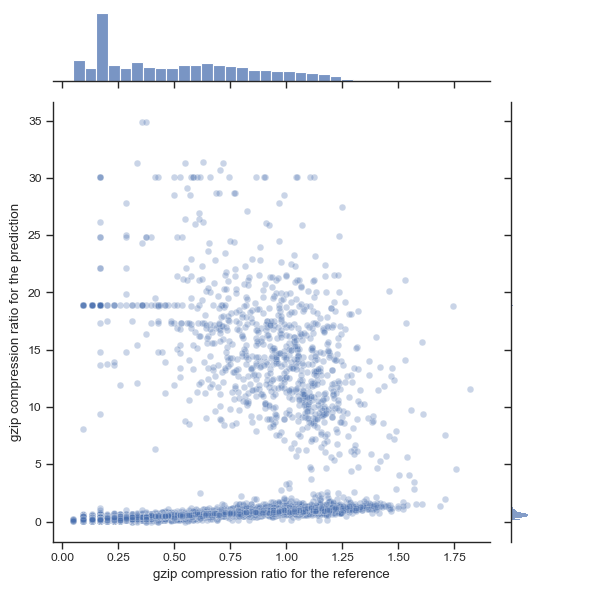

In [17]:
x_col = "references"
y_col = "predictions"

sns.jointplot(data=gzip_ratios, x=x_col, y=y_col, alpha=0.3)

plt.xlabel("gzip compression ratio for the reference")
plt.ylabel("gzip compression ratio for the prediction")
plt.tight_layout()

savepath = OUTPUT_DIR / "teacher_gzip_ratio_filtering" / "gzip_ratio_tac_pseudo_french.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")